# Introduction

Project aiming to implement the CRISP-DM analysis methodology. <br>
This methodology uses 6 steps:
1: Business Understanding,<br>
2: Data Understanding,<br>
3: Data Preparation,<br>
4: Modeling the data,<br>
5: Evaluation of the results,<br>
6: Deployment of changes based on your analysis.

## Part I: Business Understanding

The project's objective is to verify the general performance of the streets with a greater amount of evaluations, with more expensive rental prices and price by type of residence. At the end, create a machine learning model to predict rental price.

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import RepeatedStratifiedKFold
import re

In [2]:
sns.set_palette('Accent')
sns.set_style('darkgrid')

## Created Funcs

In [3]:
def float_transformation(df, columns):
    # Function created to remove the characters "$" and "," from our dataset,
    # The "price" column has these values, so the intention is to remove them to make the conversion to float.

    for i in columns:
        df[i] = df[i].str.replace('$', '').str.replace(',', '').astype('float')
        
    return df

def model_testing(modelo):
    '''
    Function created to test the instantiated models,
    For its use, it is necessary to have the models instantiated and already have the training and test data
    On its return, it will return the metric R2, training R2 and MSE
    '''
    
    modelo.fit(X_train, y_train)
    ypred = modelo.predict(X_test)
    ypred_train = modelo.predict(X_train)

    r2_test = r2_score(y_test, ypred)
    r2_train = r2_score(y_train, ypred_train)
    mse = mean_squared_error(y_test, ypred)
    
    print('R2 Score: {}, R2 train score: {}, mean_squared_error: {}'.format(r2_test, r2_train, mse))

# Part II: Data Understanding

## Reading the data

In [4]:
seatle_listings = pd.read_csv('..\Data\seatle_listings.csv', encoding='utf-8')

In [5]:
seatle_listings.shape

(3818, 92)

## Understanding the columns

First we will check how many columns have all the values and then check which ones have the most missing data.

In [6]:
# 47 columns have all values filled in
len(seatle_listings.columns[seatle_listings.isnull().mean() == 0])

47

In [7]:
# Columns with 50% of missing values
seatle_listings.columns[seatle_listings.isnull().mean() > .50]

Index(['square_feet', 'monthly_price', 'security_deposit', 'license'], dtype='object')

In [8]:
# columns with 75% of the missing values.
seatle_listings.columns[seatle_listings.isnull().mean() > .75]

Index(['square_feet', 'license'], dtype='object')

# Part III: Data Preparation

#### Columns drop with all nan and none values

In [9]:
# All values entered here are NaN, so they will be dropped.
seatle_listings['license'].unique()

array([nan])

In [10]:
seatle_listings.dropna(how = 'all', axis = 1, inplace = True)

In [11]:
# all values entered here are None, so they will also be dropped.
seatle_listings.drop('experiences_offered', axis = 1, inplace = True)

#### Checking categorical columns

In [12]:
# With this set we will check columns that are possibly numeric and are listed as str
set(seatle_listings.select_dtypes('object').columns)

{'amenities',
 'bed_type',
 'calendar_last_scraped',
 'calendar_updated',
 'cancellation_policy',
 'city',
 'cleaning_fee',
 'country',
 'country_code',
 'description',
 'extra_people',
 'first_review',
 'has_availability',
 'host_about',
 'host_acceptance_rate',
 'host_has_profile_pic',
 'host_identity_verified',
 'host_is_superhost',
 'host_location',
 'host_name',
 'host_neighbourhood',
 'host_picture_url',
 'host_response_rate',
 'host_response_time',
 'host_since',
 'host_thumbnail_url',
 'host_url',
 'host_verifications',
 'instant_bookable',
 'is_location_exact',
 'jurisdiction_names',
 'last_review',
 'last_scraped',
 'listing_url',
 'market',
 'medium_url',
 'monthly_price',
 'name',
 'neighborhood_overview',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'notes',
 'picture_url',
 'price',
 'property_type',
 'require_guest_phone_verification',
 'require_guest_profile_picture',
 'requires_license',
 'room_type',
 'security_deposit',
 'smart_locat

In [13]:
# Checking possible variables for grouping, possibly the ZIPCODE will be chosen, because the percentage of missing items is very low.
seatle_listings['zipcode'].isnull().value_counts(normalize = True)

False    0.998167
True     0.001833
Name: zipcode, dtype: float64

In [14]:
# Street is also a great option, as all values are filled in.
seatle_listings['street'].isnull().value_counts()

False    3818
Name: street, dtype: int64

# Part IV: Modeling the data

#### Conversion to numeric values

In [15]:
# Columns identified as numeric values were converted.
float_transformation(seatle_listings, seatle_listings[['extra_people', 'cleaning_fee', 'monthly_price', 'price', 'weekly_price', 'security_deposit']])

id                            listing_url       scrape_id  \
0       241032    https://www.airbnb.com/rooms/241032  20160104002432   
1       953595    https://www.airbnb.com/rooms/953595  20160104002432   
2      3308979   https://www.airbnb.com/rooms/3308979  20160104002432   
3      7421966   https://www.airbnb.com/rooms/7421966  20160104002432   
4       278830    https://www.airbnb.com/rooms/278830  20160104002432   
...        ...                                    ...             ...   
3813   8101950   https://www.airbnb.com/rooms/8101950  20160104002432   
3814   8902327   https://www.airbnb.com/rooms/8902327  20160104002432   
3815  10267360  https://www.airbnb.com/rooms/10267360  20160104002432   
3816   9604740   https://www.airbnb.com/rooms/9604740  20160104002432   
3817  10208623  https://www.airbnb.com/rooms/10208623  20160104002432   

     last_scraped                                 name  \
0      2016-01-04         Stylish Queen Anne Apartment   
1      2016-01-04   Bright & Airy Queen Anne Apartment   
2      2016-01-04  New Modern House-Amazing water view   
3      2016-01-04                   Queen Anne Chateau   
4      2016-01-04       Charming craftsman 3 bdm house   
...           ...                                  ...   
3813   2016-01-04   3BR Mountain View House in Seattle   
3814   2016-01-04    Portage Bay View!-One Bedroom Apt   
3815   2016-01-04    Private apartment view of Lake WA   
3816   2016-01-04    Amazing View with Modern Comfort!   
3817   2016-01-04            Large Lakefront Apartment   

                                                summary  \
0                                                   NaN   
1     Chemically sensitive? We've removed the irrita...   
2     New modern house built in 2013.  Spectacular s...   
3     A charming apartment that sits atop Queen Anne...   
4     Cozy family craftman house in beautiful neighb...   
...                                                 ...   
3813  Our 3BR/2BA house boasts incredible views of t...   
3814  800 square foot 1 bedroom basement apartment w...   
3815  Very comfortable lower unit. Quiet, charming m...   
3816  Cozy studio condo in the heart on Madison Park...   
3817  All hardwood floors, fireplace, 65" TV with Xb...   

                                                  space  \
0     Make your self at home in this charming one-be...   
1     Beautiful, hypoallergenic apartment in an extr...   
2     Our house is modern, light and fresh with a wa...   
3                                                   NaN   
4     Cozy family craftman house in beautiful neighb...   
...                                                 ...   
3813  Our 3BR/2BA house bright, stylish, and wheelch...   
3814  This space has a great view of Portage Bay wit...   
3815                                                NaN   
3816  Fully furnished unit to accommodate most needs...   
3817                                                NaN   

                                            description  \
0     Make your self at home in this charming one-be...   
1     Chemically sensitive? We've removed the irrita...   
2     New modern house built in 2013.  Spectacular s...   
3     A charming apartment that sits atop Queen Anne...   
4     Cozy family craftman house in beautiful neighb...   
...                                                 ...   
3813  Our 3BR/2BA house boasts incredible views of t...   
3814  800 square foot 1 bedroom basement apartment w...   
3815  Very comfortable lower unit. Quiet, charming m...   
3816  Cozy studio condo in the heart on Madison Park...   
3817  All hardwood floors, fireplace, 65" TV with Xb...   

                                  neighborhood_overview  \
0                                                   NaN   
1     Queen Anne is a wonderful, truly functional vi...   
2     Upper Queen Anne is a charming neighborhood fu...   
3                                                   NaN   
4     We are in 

#### Selecting values to be entered in the weekly value column

I preferred to use this methodology than remove the columns, so it would still have a value to work with and would not "throw away" dataset information.

In [16]:
id_price = seatle_listings.groupby(['id'])['price'].sum()

In [17]:
seatle_listings['id'][seatle_listings['weekly_price'].isnull() == True].map(id_price * 7)

0        595.0
2       6825.0
4       3150.0
13      1155.0
14      3227.0
         ...  
3811     455.0
3813    2513.0
3814     553.0
3816     693.0
3817     609.0
Name: id, Length: 1809, dtype: float64

In [18]:
# Part used to add value in weekly_price column
# I decided to follow the path in which the daily rate * 7 was selected to reach the weekly rate
seatle_listings.loc[:, 'weekly_price'][seatle_listings['weekly_price'].isnull()] = (seatle_listings['id'][seatle_listings['weekly_price'].isnull() == True]
                                                                                    .map(id_price * 7))

C:\Users\Kaiqu\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


The above process worked. In the end, we want the maximum number of values filled in, so it was the method I found most suitable to fill in the data in a "real" way. I'm not taking into consideration if the owner of the place can apply discounts on weekly/monthly packages.

We will use the same process to fill in the monthly amounts.

In [19]:
# 60% of null data, we will fill them with weekly values x4
seatle_listings.loc[:, 'monthly_price'].isnull().value_counts(normalize = True)

True     0.602672
False    0.397328
Name: monthly_price, dtype: float64

In [20]:
# This part of the code may have been a little confusing, but it was the most suitable way I found to map only null values 
# and not end up overwriting already filled values

wk_price = seatle_listings.groupby(['id'])['weekly_price'].sum()
seatle_listings.loc[:, 'monthly_price'][seatle_listings['monthly_price'].isnull()] = (seatle_listings['id'][seatle_listings['monthly_price'].isnull() == True]
                                                                                    .map(wk_price * 4))

C:\Users\Kaiqu\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [21]:
seatle_listings['monthly_price'].isnull().value_counts(normalize=True)

False    1.0
Name: monthly_price, dtype: float64

In [22]:
# Now, moving on to our last numeric variable (of prices), for cleaning rate, the null values will be filled with 0

seatle_listings['cleaning_fee'].fillna(0, inplace = True)

In [23]:
# checking for variables that still have null values
seatle_listings.columns[seatle_listings.isnull().mean()>0]

Index(['summary', 'space', 'neighborhood_overview', 'notes', 'transit',
       'thumbnail_url', 'medium_url', 'xl_picture_url', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'zipcode', 'property_type', 'bathrooms', 'bedrooms', 'beds',
       'square_feet', 'security_deposit', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month'],
      dtype='object')

In [24]:
seatle_listings['review_scores_value'].isnull().value_counts(normalize=True)

False    0.828182
True     0.171818
Name: review_scores_value, dtype: float64

In [25]:
# we will drop the zip codes that are not present, so we can use it as a review mapper
seatle_listings.dropna(subset=['zipcode'], axis = 0, inplace = True)

In [26]:
review_scores_value_per_zipcode = round(seatle_listings.groupby(['zipcode'])['review_scores_value'].mean(), 2)

In [27]:
# Used to fill in the null values of the review_score_value variable
# the methodology was to use the average of the evaluations of X postal code
seatle_listings.loc[:, 'review_scores_value'][seatle_listings['review_scores_value'].isnull() == True] = (seatle_listings['zipcode']
                                                                                                          .map(review_scores_value_per_zipcode))

C:\Users\Kaiqu\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [28]:
# variable that represents the response time, if it responds within 1 hour, 1 day, etc... We will consider it category and replace it
# its values for numerics representing its categories (nan values will be filled in as -1)
seatle_listings['host_response_time'] = seatle_listings['host_response_time'].astype('category').cat.codes

#### Dropping some categorical columns.

The criteria used to drop the columns were:

Columns that report the same value over and over, this hinders our future model's ability to handle generalized information,
URL's and images. (Columns that had equal values were also removed)

My first idea was to remove columns that contained more than 10 characters in their values, but I didn't follow through with this idea. I preferred to look at each column of these categories and decide which would be of greater relevance or not.

In [29]:
# selection of columns to be dropped
cat_cols=seatle_listings.select_dtypes('object').columns

In [30]:
drop_list = ['listing_url', 'last_scraped', 'name', 'space', 'notes', 'transit',
            'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
            'host_url', 'host_name', 'host_since', 'host_about',
            'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
            'host_has_profile_pic', 'neighbourhood', 'city', 'state', 'market', 
            'smart_location', 'country_code', 'country',
            'has_availability', 'first_review', 'last_review', 
            'requires_license', 'jurisdiction_names', 'summary', 'host_id', 'host_acceptance_rate',
            'id', 'scrape_id', 'host_verifications']

In [31]:
# in the end, we managed to balance the categorical and quantitative variables.
len(cat_cols) - len(drop_list)

18

In [32]:
len(seatle_listings.select_dtypes('float').columns)

22

In [33]:
seatle_listings.drop(drop_list, axis = 1, inplace = True)

In [34]:
# one more correction of a column that should be numeric and was as a string
seatle_listings['host_response_rate'] = seatle_listings['host_response_rate'].str.replace('%', '').astype('float')

#### Extraction of words from descriptions


So that we can use the neighborhood description and general information columns, I selected some keywords.<br>
The goal is to count how many times the keywords appear, so that we have some column information to use in the future (the same methodology will be applied in the description)

In [35]:
word_list = ['charming', 'beautifull', 'spectacular', 'cozy', 'comfortable',
            'wondeful', 'quiet', 'view', 'close', 'gorgeous', 'pets', 'cat', 'dog',
            'family', 'calm', 'peacefull', 'safe', 'police', 'bus', 'uber', 'taxi']

In [36]:
# Methodology found below in stack overflow
# Link: https://stackoverflow.com/questions/62619082/check-if-column-in-data-frame-contain-any-word-from-a-list-adding-count-pytho
search = re.compile("\\b%s\\b" % "\\b|\\b".join(word_list), flags = re.IGNORECASE)

In [37]:
seatle_listings['description'] = seatle_listings['description'].str.findall(search).apply(len)
# let's give a fillna with the value 0 in the neighborhood overview variable, because since we're going to make it numeric, the 0 will fill the nan values
seatle_listings.loc[:, 'neighborhood_overview'][seatle_listings['neighborhood_overview'].isnull()==False] = (
    seatle_listings.loc[:, 'neighborhood_overview'][seatle_listings['neighborhood_overview'].isnull()==False].str.findall(search).apply(len))

C:\Users\Kaiqu\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [38]:
seatle_listings['neighborhood_overview'].fillna(int(0), inplace = True)
seatle_listings['neighborhood_overview'] = seatle_listings['neighborhood_overview'].astype('int')

In [39]:
# hosts that have no response time will be classified as 0 time as well.
seatle_listings['host_response_rate'].fillna(0, inplace =True)

In [40]:
# check for columns that still have nulls.
seatle_listings.isnull().mean()

description                         0.000000
neighborhood_overview               0.000000
host_location                       0.002099
host_response_time                  0.000000
host_response_rate                  0.000000
host_is_superhost                   0.000525
host_listings_count                 0.000525
host_total_listings_count           0.000525
host_identity_verified              0.000525
street                              0.000000
neighbourhood_cleansed              0.000000
neighbourhood_group_cleansed        0.000000
zipcode                             0.000000
latitude                            0.000000
longitude                           0.000000
is_location_exact                   0.000000
property_type                       0.000262
room_type                           0.000000
accommodates                        0.000000
bathrooms                           0.004198
bedrooms                            0.001574
beds                                0.000262
bed_type  

In [41]:
# columns that have a small value of nuls
seatle_listings.dropna(subset = ['host_location', 'host_is_superhost', 'host_listings_count', 'host_total_listings_count'], axis = 0, inplace = True)
seatle_listings.dropna(subset = ['beds', 'bathrooms', 'bathrooms', 'bedrooms'], axis = 0, inplace = True)

In [42]:
# column has 97% of its value as null, cant fill it with anything
seatle_listings.drop(columns='square_feet', inplace = True)

In [43]:
# those who have not received evaluations or who do not charge amounts in advance will be filled in with 0
seatle_listings['reviews_per_month'].fillna(0, inplace = True)
seatle_listings['security_deposit'].fillna(0, inplace = True)

In [44]:
# I cannot replace any of these values, nor fill them in, as they are important assessments, so we will drop the nulls
seatle_listings[['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 
                 'review_scores_checkin', 'review_scores_communication', 'review_scores_location']]

review_scores_rating  review_scores_accuracy  review_scores_cleanliness  \
0                     95.0                    10.0                       10.0   
1                     96.0                    10.0                       10.0   
2                     97.0                    10.0                       10.0   
3                      NaN                     NaN                        NaN   
4                     92.0                     9.0                        9.0   
...                    ...                     ...                        ...   
3813                  80.0                     8.0                       10.0   
3814                 100.0                    10.0                       10.0   
3815                   NaN                     NaN                        NaN   
3816                   NaN                     NaN                        NaN   
3817                   NaN                     NaN                        NaN   

      review_scores_checkin  review_scores_communication  \
0                      10.0                         10.0   
1                      10.0                         10.0   
2                      10.0                         10.0   
3                       NaN                          NaN   
4                      10.0                         10.0   
...                     ...                          ...   
3813                    4.0                          8.0   
3814                   10.0                         10.0   
3815                    NaN                          NaN   
3816                    NaN                          NaN   
3817                    NaN                          NaN   

      review_scores_location  
0                        9.0  
1                       10.0  
2                       10.0  
3                        NaN  
4                        9.0  
...                      ...  
3813                    10.0  
3814                    10.0  
3815                     NaN  
3816                     NaN  
3817                     NaN  

[3781 rows x 6 columns]

In [45]:
seatle_listings.dropna(axis = 0, how = 'any', inplace = True)

#### Street extraction

In [46]:
# first of all, let's reset the index
# As street names are allocated in the first part of the sentence, we will only consider this part as the street name.
seatle_listings.reset_index(inplace = True, drop=True)
seatle_listings['street'] = seatle_listings['street'].str.rsplit(',').str[0]

In [47]:
# CEP = Zipcode
cep=seatle_listings['zipcode'].unique()[10]

In [48]:
# correcting strange zip code
seatle_listings.query('zipcode in @cep')

description  neighborhood_overview host_location  host_response_time  \
715            1                      0            US                   1   

     host_response_rate host_is_superhost  host_listings_count  \
715                60.0                 f                  3.0   

     host_total_listings_count host_identity_verified    street  ...  \
715                        3.0                      t  14th Ave  ...   

    review_scores_checkin review_scores_communication review_scores_location  \
715                  10.0                        10.0                   10.0   

     review_scores_value  instant_bookable cancellation_policy  \
715                 10.0                 f            flexible   

    require_guest_profile_picture require_guest_phone_verification  \
715                             f                                f   

     calculated_host_listings_count  reviews_per_month  
715                               3                1.0  

[1 rows x 53 columns]

In [49]:
seatle_listings.loc[715, 'zipcode'] = seatle_listings.loc[715, 'zipcode'][3:]

# Part V: Evaluation of the results

## Performance verification

### Which streets have the highest allocation prices?

To answer this question, we will proceed with a groupby street and select the average price. We will treat the first 10 streets with the highest prices so that in other views we can identify (based on the selected methodologies) if the more expensive ones have more ratings, etc...

In [50]:
mean_street_price = seatle_listings.groupby(['street'])['price'].mean().sort_values(ascending = False).head(10)

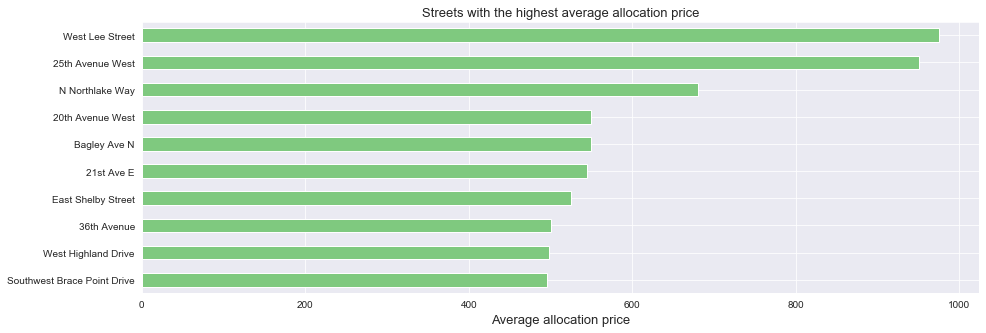

In [51]:
ax = mean_street_price.sort_values(ascending = True).plot(kind = 'barh', figsize = (15,5))
ax.set_ylabel('')
ax.set_title('Streets with the highest average allocation price', fontsize = 13)
ax.set_xlabel('Average allocation price', fontsize = 13);

### Which streets used the keywords the most?


As I determined when dealing with the data, some keywords were selected and the count in which they appear in the descriptions was added, so we will use this to check the streets that most used these keywords.

In [52]:
street_key_word = seatle_listings.groupby(['street'])['description'].sum().sort_values(ascending = False).head(10)

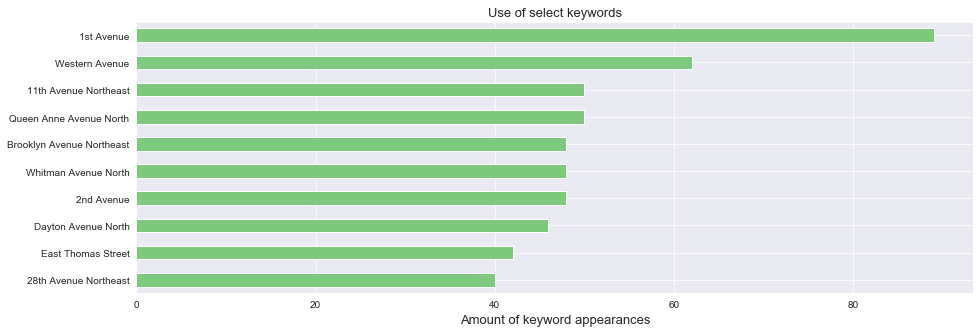

In [53]:
ax = street_key_word.sort_values(ascending=True).plot(kind='barh', figsize=(15,5))
ax.set_ylabel('')
ax.set_title('Use of select keywords', fontsize = 13)
ax.set_xlabel('Amount of keyword appearances', fontsize = 13);

### Which streets have the highest ratings counts?

Based on the previous view, my idea is to check if the streets with the highest average price have the highest amounts of user reviews as well, and possibly justifying the high prices due to high rental demand.

In [54]:
evaluation_count = seatle_listings.groupby('street')['review_scores_value'].count().sort_values(ascending = False).head(10)

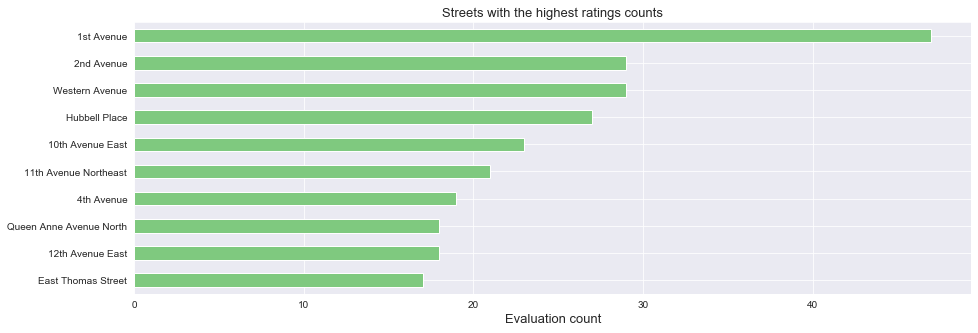

In [55]:
ax = evaluation_count.sort_values(ascending = True).plot(kind ='barh', figsize=(15,5))
ax.set_ylabel('')
ax.set_title('Streets with the highest ratings counts', fontsize = 13)
ax.set_xlabel('Evaluation count', fontsize = 13);

And as a result we can see that in fact, the streets that most used the selected keywords are the ones that have the most ratings (at least the majority), and not the ones that have the highest prices.

### What is the average amount charged by property type?

The intention of this visualization is to take a base of how much is charged on average per type of residence

In [56]:
property_charge_mean = seatle_listings.groupby(['property_type'])['price'].mean().sort_values()

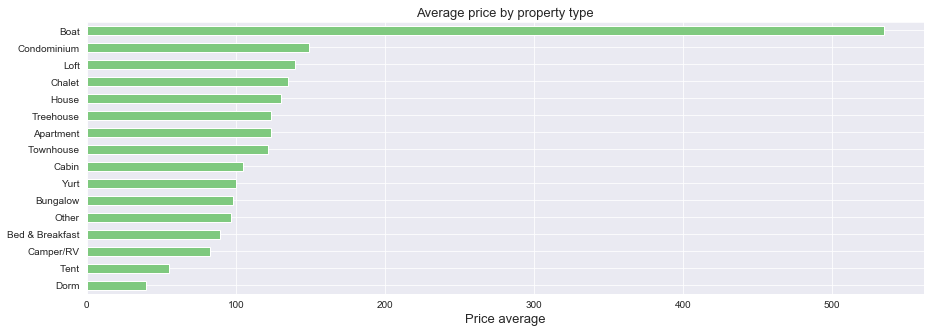

In [57]:
ax = property_charge_mean.sort_values(ascending = True).plot(kind='barh', figsize=(15,5))
ax.set_title('Average price by property type', fontsize=13)
ax.set_ylabel('')
ax.set_xlabel('Price average', fontsize=13);

### Which properties have the most reviews?

In [58]:
property_review_count = seatle_listings.groupby(['property_type'])['review_scores_value'].count().sort_values(ascending = True)

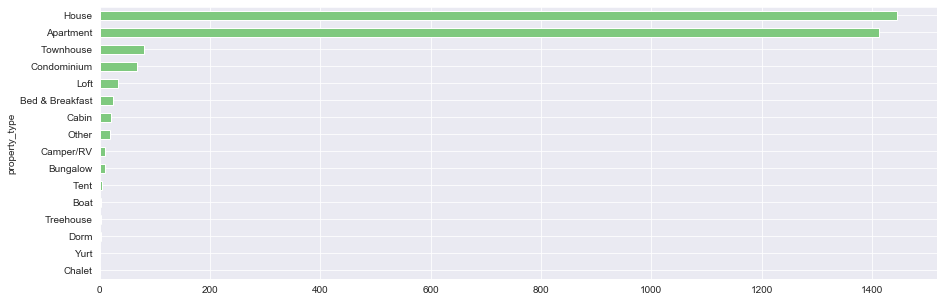

In [59]:
property_review_count.plot(kind = 'barh', figsize=(15,5))

## Linear model instantiation

#### Test I::
Verification of model metrics without data stratification

In [60]:
#part of the code used to acquire the dummies of our categorical variables

new_cat_cols = seatle_listings.select_dtypes('object').columns
for col in new_cat_cols:
    seatle_listings = pd.concat([seatle_listings.drop(col, axis = 1), pd.get_dummies(seatle_listings[col], drop_first=True, prefix=col)], axis = 1) 

In [61]:
linear = LinearRegression(normalize=True)
ridgecv = RidgeCV(normalize=True)
sgd = SGDRegressor()
ridge = Ridge()

In [62]:
X = seatle_listings.drop('price', axis = 1)
y = seatle_listings['price']

In [63]:
# separation of our data for training and testing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [64]:
model_testing(linear)

R2 Score: -2.2614168658872584e+23, R2 train score: 0.998519551834112, mean_squared_error: 1.8085687096697715e+27


In [65]:
model_testing(ridgecv)

R2 Score: 0.8376787346266902, R2 train score: 0.9925329015615978, mean_squared_error: 1298.164729805315


In [66]:
model_testing(sgd)

R2 Score: -6.72019858091798e+26, R2 train score: -4.076212058909751e+27, mean_squared_error: 5.374480512440552e+30


In [67]:
model_testing(ridge)

R2 Score: 0.9397725711445206, R2 train score: 0.9881932587489705, mean_squared_error: 481.6690143908779


The model that uses light stratification did a little better, so I will stratify the data and then instantiate the model

#### Test II: 
Stratified data


In [68]:
cv = RepeatedStratifiedKFold()
cv.get_n_splits(X,y)

50

In [69]:
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.T[train_index], X.T[test_index]
    y_train, y_test = y[train_index], y[test_index]

C:\Users\Kaiqu\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Kaiqu\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Kaiqu\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Kaiqu\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Kaiqu\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least

In [70]:
X_train, X_test = X_train.T, X_test.T

In [71]:
linear = LinearRegression(normalize=True)
ridgecv = RidgeCV(normalize=True)
sgd = SGDRegressor()
ridge = Ridge()

In [72]:
model_testing(linear)

R2 Score: -1.0652988397548657e+24, R2 train score: 0.9933919030180484, mean_squared_error: 8.299872319917387e+27


In [73]:
model_testing(ridgecv)

R2 Score: 0.8316849550763882, R2 train score: 0.9927559307787094, mean_squared_error: 1311.3629061199365


In [74]:
model_testing(sgd)

R2 Score: -1.732456185659657e+26, R2 train score: -5.238867289697947e+26, mean_squared_error: 1.3497776026992586e+30


In [75]:
model_testing(ridge)

R2 Score: 0.9473218094776366, R2 train score: 0.9877240018284238, mean_squared_error: 410.42216424501794


Checking the distribution of our y variable, it is left asymmetric.<br>
So to try to leave it with a normal distribution, I will use its logarithm.

#### Test III:
Use of logarithm of variable y to acquire a normal distribution

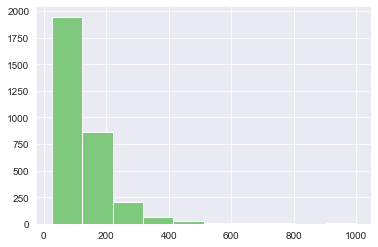

In [76]:
y.hist()

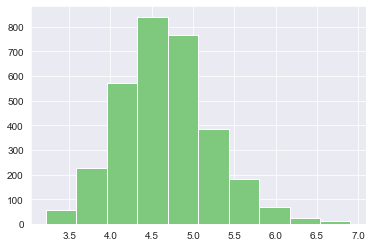

In [77]:
# to revert to its original state, just use np.exp()
y_log = np.log(y)
y_log.hist()

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.3, random_state=42)

linear = LinearRegression(normalize=True)
ridgecv = RidgeCV(normalize=True)
sgd = SGDRegressor()
ridge = Ridge()

In [79]:
model_testing(linear)

R2 Score: -4.211979988711582e+23, R2 train score: 0.9971553614859504, mean_squared_error: 1.30698771622944e+23


In [80]:
model_testing(ridgecv)

R2 Score: 0.7989374210380171, R2 train score: 0.996190640592043, mean_squared_error: 0.062390211159837


In [81]:
model_testing(sgd)

R2 Score: -8.402775754076422e+30, R2 train score: -1.8051971746610008e+31, mean_squared_error: 2.607401916020945e+30


In [82]:
model_testing(ridge)

R2 Score: 0.8693280173635368, R2 train score: 0.9796807514732234, mean_squared_error: 0.0405478365564236


The models performed a little better, I will test with stratified data now to see if there is any improvement

#### Teste IV: 
Using logarithm and stratified data

In [83]:
np.random.seed(42)

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.T[train_index], X.T[test_index]
    y_train, y_test = y_log[train_index], y_log[test_index]

C:\Users\Kaiqu\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Kaiqu\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Kaiqu\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Kaiqu\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Kaiqu\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least

In [84]:
X_train, X_test = X_train.T, X_test.T

In [85]:
X_train, X_test = X_train.reset_index(drop=True), X_test.reset_index(drop=True)
y_train, y_test = y_train.reset_index(drop=True), y_test.reset_index(drop=True)

In [86]:
linear = LinearRegression(normalize=True)
ridgecv = RidgeCV(normalize=True)
sgd = SGDRegressor()
ridge = Ridge()

In [87]:
model_testing(linear)

R2 Score: -2.549680399215677e+24, R2 train score: 0.979776262335905, mean_squared_error: 7.771126521526088e+23


In [88]:
model_testing(ridgecv)

R2 Score: 0.7891321772367623, R2 train score: 0.9953665796512651, mean_squared_error: 0.06427003676680194


In [89]:
model_testing(sgd)

R2 Score: -5.693069842206057e+31, R2 train score: -1.0719207840890937e+32, mean_squared_error: 1.7351808506382701e+31


In [90]:
# winner!
model_testing(ridge)

R2 Score: 0.8663619214605484, R2 train score: 0.9793070240792004, mean_squared_error: 0.040731317413083785


#### Checking some results

In [91]:
ridge.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [92]:
# result with predict
np.exp(ridge.predict(X_test.iloc[:10, :]))

array([ 91.43929108,  90.53060899, 160.59895607, 130.97366076,
        66.48100486, 116.69156436, 874.17584335, 127.56073374,
       132.20963495,  70.67083575])

In [93]:
# Original result
np.exp(y_test[:10])

0    120.0
1     90.0
2    165.0
3    109.0
4     66.0
5    110.0
6    600.0
7    150.0
8    130.0
9     70.0
Name: price, dtype: float64

# Part VI: Deployment of changes based on your analysis.

## Conclusions

I would like to let you know that in no way the methodologies I used are completely correct, but they were the ones I thought was best to use.

During the process to adjust the data, it was by far the most complicated, as the data has a lot of information to be used, but I focused on what I considered most useful for this analysis. I looked for some answers on stackoverflow because I had no idea how to proceed, and in a way, I imagine that in the end everything worked out. Not to mention the excessive count of NaN values.

During the visualization process, we saw at the beginning the streets with the highest allocation price, we saw the streets that most used the keywords we defined previously, the ones that have the most ratings, the most interesting thing is that a good part of the streets with more use of the keywords were the ones that received the most reviews! So we can, in a way, say that the description using certain words can help the location to be rented. We also saw the types of "residences" that were for rent, I was impressed that even boats are allocated by airbnb, we also checked the types of properties that have the most valuations which were mostly houses and apartments and the average price of these properties.

In part of our machine learning model, it was very complicated and it took me a few days to get the current result.<br>
Initially I would only do with the `LinearRegression` model that was seen in class, however its metrics were very bad (This is due to how my data was in its final state, not because of the model), so I started looking for others models it could test. So I found `RidgeCV`, selected it because models that handle
cross-validation tend to generalize better when fitted to the data. As the data verification process took me a lot of time, I had no ideas of what to do to try to change the result based on the data, so I focused on testing other models), after the RidgeCV tests were *slightly better*, I tried to add a few more models (including the `Ridge` model, which performed better). <br>

After some light testing, to check the mean square error and the R2 score, as the RidgeCV model had performed a little better, I thought about doing the _stratification in the data_ and seeing the behavior of the other models (which didn't change much), and the more interesting is that apart from the cross-validation of RidgeCV itself, with the stratified data *it performed a little better*. It was at this point that I decided to test the Ridge model, with stratified data and without, and its performance was superior to all other models, but the quadratic error was still intriguing me, as it was at a value I was not used to seeing.<br>

After testing the Ridge model, I remembered seeing somewhere that when the distribution of the target variable is not normal, the model can be in trouble and have different results, so I remembered that in some cases, instead of using the value real, we could use the logarithmic value to try to acquire a *normal distribution*, and that's what happened in our case (I don't know if this was the best decision to make, but it seems to me so based on my limited knowledge of machine learning). After the changes made to the training and testing data, the Ridge methodology came very close to the expected results, the model did not get an overfit, with an acceptable R2 value and a quadratic error below 0.05 (at the limit, but below), and it was with this result that I decided to concede that this model would be suitable for predictions with the data I had chosen.